In [1]:
from langgraph.graph import MessagesState, StateGraph, END, START
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_community.tools import DuckDuckGoSearchRun
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from typing import Annotated, TypedDict
import operator
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from langchain_groq import ChatGroq


In [2]:
llm = ChatGroq(model_name = "Gemma2-9b-It")
llm.invoke("Hey there").content

'Hey there! 👋 What can I do for you today? 😊\n'

In [3]:
def multiply(a: int, b: int)-> int:
    """Multiply a and b"""
    return a * b


In [4]:
def add(a:int, b:int)->int:
    """Add a and b"""
    return a + b

In [5]:
def divide(a:int, b:int)-> float:
    """divides two numbers"""
    return a / b

In [6]:
search = DuckDuckGoSearchRun()

In [7]:
search.invoke("What is the name of the current president of USA?")

'The White House, official residence of the president of the United States The president of the United States is the head of state and head of government of the United States, [1] indirectly elected to a four-year term via the Electoral College. [2] Under the U.S. Constitution, the officeholder leads the executive branch of the federal government and is the commander-in-chief of the United ... Donald J. Trump is the President of the USA in 2025 after a landslide re-election victory. Explore his achievements, policies, and historic second term. Donald Trump, who overcame impeachments, criminal indictments and a pair of assassination attempts to win another term in the White House, was sworn in Monday as the 47th U.S. president taking ... Donald Trump has officially taken the oath of office as the 47th President of the United States. Donald Trump is once again President of the United States. Credit: Chip Somodevilla/Getty Trump, 78, was officially sworn in as the 47th President of the Un

In [8]:
tools = [add, multiply, divide, search]

In [9]:
llm_with_tools = llm.bind_tools(tools)

In [10]:
sys_message = SystemMessage(content="You are a helpful assistant tasked with using search and performing arithmetic on a set of inputs.")

In [11]:
def reasoner(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_message] + state['messages'])]}

In [12]:
workflow = StateGraph(MessagesState)
workflow.add_node("reasoner", reasoner)
workflow.add_node("tools", ToolNode(tools))
workflow.add_edge(START, "reasoner")

workflow.add_conditional_edges(
    "reasoner",
     # If the latest message (result) from node reasoner is a tool call -> tools_condition routes to tools
     # If the latest message (result) from node reasoner is a not a tool call -> tools_condition routes to END
     tools_condition,
)

workflow.add_edge("tools", "reasoner")
react_graph = workflow.compile()             

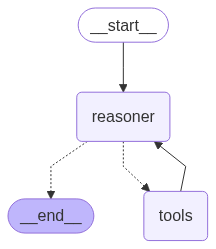

In [13]:
#display the graph 
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [14]:
messages = [HumanMessage(content="What is Eleon musk age?")]
messages = react_graph.invoke({"messages": messages})

In [15]:
for msg in messages['messages']:
    msg.pretty_print()

================================ Human Message =================================

What is Eleon musk age?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (bz8s8asvs)
 Call ID: bz8s8asvs
  Args:
    query: Elon Musk age
================================= Tool Message =================================
Name: duckduckgo_search

Learn about Elon Musk's age, wife, girlfriend, children, family, and achievements. Find out his controversies, such as his tweets, lawsuits, and Twitter deal. Elon Musk has made cameos in several movies and television shows. His life will be turned into a future movie. Musk has had a love of video games since an early age, including creating and selling ... Elon Musk is founder of Tesla Motors and SpaceX among other companies. Read about his net worth, children, ex-wives, age, home country, DOGE position, and more. Explore Elon Musk's remarkable journey as an entrepreneur, his age, marriages, and his nu

In [18]:

messages = [HumanMessage(content="What is the result when you add 100 years to the current age of Elon Musk?")]
messages = react_graph.invoke({"messages": messages})


In [19]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the result when you add 100 years to the current age of Elon Musk?
================================== Ai Message ==================================
Tool Calls:
  add (n5nmnaz5m)
 Call ID: n5nmnaz5m
  Args:
    a: 100
    b: 51
================================= Tool Message =================================
Name: add

151
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (d20mt6ztz)
 Call ID: d20mt6ztz
  Args:
    query: When was Elon Musk born?
================================= Tool Message =================================
Name: duckduckgo_search

and SpaceX. Musk is also one of the most followed and popular figures in the world. Born as Elon Reeve Musk on June 28, 1971 in South Africa, Musk celebrates his 54th birthday in 2025. Here's what to know about Elon Musk's citizenship, nationality, net worth and how tall is he? Where was Elo

In [20]:
import yfinance as yf
def get_stock_price(ticker: str) ->float:
    """Get stock price from Yahoo Finance"""
    stock = yf.Ticker(ticker)
    return stock.info['previousClose']
get_stock_price("AAPL")

212.44

In [23]:
#node
def reasoner(state):
    query = state['query']
    messages = state['messages']
    sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search, the yahoo finance tool and performing arithmetic on a set of inputs.")
    message = HumanMessage(content=query)
    messages.append(message)
    result = [llm_with_tools.invoke([sys_msg] + messages)]
    return {"messages": result}

In [22]:
tools = [add, multiply, divide, search, get_stock_price]

In [25]:
llm_with_tools = llm.bind_tools(tools)

In [30]:
class GraphState(TypedDict):
    """state of the graph"""
    query: str
    finance: str
    final_answer: str
    messages: Annotated[list[AnyMessage], operator.add]

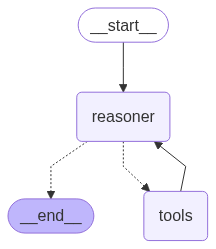

In [31]:
# Graph
workflow = StateGraph(GraphState)

# Add Nodes
workflow.add_node("reasoner", reasoner)
workflow.add_node("tools", ToolNode(tools)) # for the tools

# Add Edges
workflow.add_edge(START, "reasoner")

workflow.add_conditional_edges(
    "reasoner",
    # If the latest message (result) from node reasoner is a tool call -> tools_condition routes to tools
    # If the latest message (result) from node reasoner is a not a tool call -> tools_condition routes to END
    tools_condition,
)
workflow.add_edge("tools", "reasoner")
react_graph = workflow.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))
     

In [32]:
response = react_graph.invoke({"query": "What is the stock price of Apple add 1000?", "messages": []})
     

In [33]:

for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the stock price of Apple add 1000?
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (6k2arp85e)
 Call ID: 6k2arp85e
  Args:
    ticker: AAPL
================================= Tool Message =================================
Name: get_stock_price

212.44
================================ Human Message =================================

What is the stock price of Apple add 1000?
================================== Ai Message ==================================

212.44 + 1000 = 1212.44
